In [1]:
data_file_path = 'OriginalData/'

In [2]:
import numpy as np
import pandas as pd
import os
import re
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.utils import resample
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn import metrics

227 users found in users directory

169 has parkinson, impact: 67 mild, 74 medium, 24 severe, 4 unknown

58 no parkinson, 3 of them has mild impact tremor

----

217 users appear in TappyData, 49 non users appear in TappyData (discard).

217 users, 162 positive, 55 negative

In [3]:
rows = []
colNames = ['BirthYear','Gender','Parkinsons','Tremors','DiagnosisYear','Sided','UPDRS','Impact','Levadopa','DA','MAOB','Other']
users = []

userFolder = data_file_path + 'Users'

for userFilename in os.listdir(userFolder):
    users.append(userFilename[5:-4])

    f = open(os.path.join(userFolder, userFilename))
    lines = f.readlines()

    row = []
    col = []

    for line in lines:
        line = line[:-1]
        lineSplit = line.split(': ')
        
        row.append(lineSplit[1])
        col.append(lineSplit[0])
            
    if col == colNames:
        rows.append(row)
    else:
        print(userFilename+'read wrong.')

    f.close()

userDF = pd.DataFrame(rows, columns=colNames, index=users)
userDF.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
0EA27ICBLF,1952,Female,True,True,2000,Left,Don't know,Severe,True,True,False,False
0QAZFRHQHW,1959,Female,False,False,------,None,Don't know,------,False,False,False,False
0WTDIGPSBZ,1946,Female,False,False,------,None,Don't know,------,False,False,False,False
1HOEBIGASW,1944,Male,False,False,------,None,Don't know,------,False,False,False,False
1WMVCCU4RH,1953,Male,True,True,2017,Left,Don't know,Medium,False,False,False,False


In [11]:
rows = []
colNames = ['UserID','Date','Timestamp','Hand','HoldTime','Direction','LatencyTime','FlightTime']
userSet = set()
nonUserSet = set()

dataFolder = data_file_path + 'TappyData'
invalid = [0,0,0,0,0,0,0,0,0]
count = 0
for dataFilename in os.listdir(dataFolder):
    infoArr = dataFilename[:-4].split('_')
    userID = infoArr[0]
    if userID not in userDF.index:
        continue
    yearMonth = infoArr[1]

    f = open(os.path.join(dataFolder, dataFilename))
    lines = f.readlines()

    row = []
    
    for line in lines:
        line = line[:-1]
        line_len = len(line)
        occur = [m.start() for m in re.finditer('(?='+userID+')', line)]
        occur_count = len(occur)
        for idx in range(occur_count):
            occur_idx = occur[idx]
            next_idx = occur[idx+1] if idx < occur_count - 1 else line_len
            
            cur_line = line[occur_idx:next_idx]
            lineSplit = cur_line.split('\t')

            if lineSplit[0] != userID:
                print(lineSplit)
            elif len(lineSplit) < 8:
                pass
            else:
                try:
                    lineSplit[4] = float(lineSplit[4])
                    lineSplit[6] = float(lineSplit[6])
                    lineSplit[7] = float(lineSplit[7])
                    rows.append(lineSplit[0:8])
                except ValueError:
                    pass
    f.close()
dataDF = pd.DataFrame(rows, columns=colNames)
dataDF.head()

,UserID,Date,Timestamp,Hand,HoldTime,Direction,LatencyTime,FlightTime
0,0EA27ICBLF,160722,18:41:04.336,L,101.6,LL,234.4,156.3
1,0EA27ICBLF,160722,18:42:14.070,L,85.9,LL,437.5,359.4
2,0EA27ICBLF,160722,18:42:14.273,L,78.1,LL,210.9,125.0
3,0EA27ICBLF,160722,18:42:14.617,L,62.5,LL,359.4,281.3
4,0EA27ICBLF,160722,18:42:15.586,S,125.0,LS,187.5,93.8


In [104]:
test = dataDF[dataDF['Hand'].isin(['L','R','S']) & dataDF['Direction'].isin(['LL','LR','LS','RL','RR','RS','SL','SR','SS']) & (dataDF['HoldTime'] < 10000)]
test = test.dropna()
test = test.drop_duplicates()
test = test.groupby(['UserID','Date']).filter(lambda group: len(group) >= 50)
grouped = test.groupby(['UserID','Date'])

In [114]:
pos = []
neg = []
for id in test['UserID'].unique():
    if userDF.loc[id]['Parkinsons'] == 'True':
        pos.append(id)
    elif userDF.loc[id]['Parkinsons'] == 'False':
        neg.append(id)
    else:
        print('!')
pos_train = random.sample(pos, 103)
pos_test = random.sample([x for x in pos if x not in pos_train], 44)

neg_train = random.sample(neg, 34)
neg_test = random.sample([x for x in neg if x not in neg_train], 15)

In [ ]:
196
147 + 49
103 + 44 + 34 + 15
8797607
6285564 + 2512043
4458490 + 1827074 + 1755268 + 756775
6232
4780 + 1452
3514 + 1266 + 998 + 454

In [158]:
for name, group in grouped:
    filename = '_'.join([name[0],name[1]])
    if name[0] in pos_train:
        folder = 'data_new/train/pos/'
    if name[0] in pos_test:
        folder = 'data_new/test/pos/'
    if name[0] in neg_train:
        folder = 'data_new/train/neg/'
    if name[0] in neg_test:
        folder = 'data_new/test/neg/'
    group['Timestamp'] = pd.to_datetime(group['Timestamp'], format='%H:%M:%S.%f').dt.time
    group = group.sort_values('Timestamp')
    group.to_csv(folder+filename+'.csv', index=False, header=False)

---

In [169]:
test.head()

,UserID,Date,Timestamp,Hand,HoldTime,Direction,LatencyTime,FlightTime
0,0EA27ICBLF,160722,18:41:04.336,L,101.6,LL,234.4,156.3
1,0EA27ICBLF,160722,18:42:14.070,L,85.9,LL,437.5,359.4
2,0EA27ICBLF,160722,18:42:14.273,L,78.1,LL,210.9,125.0
3,0EA27ICBLF,160722,18:42:14.617,L,62.5,LL,359.4,281.3
4,0EA27ICBLF,160722,18:42:15.586,S,125.0,LS,187.5,93.8


In [170]:
def buildRows(posFolder, negFolder):
    rows = []
    for filename in os.listdir(posFolder) + os.listdir(negFolder):
        pos = filename in os.listdir(posFolder)
        userid = filename.split('_')[0]
        f = open(os.path.join(posFolder, filename)) if pos else open(os.path.join(negFolder, filename))
        lines = f.readlines()

        featureArr = []

        for line in lines:
            line = line[:-1]
            lineSplit = line.split(',')
            try:
                holdtime = float(lineSplit[4])
                latencytime = float(lineSplit[6])
                flighttime = float(lineSplit[7])
                featureArr.append([holdtime,latencytime,flighttime])
            except ValueError:
                pass
        if len(featureArr) >= 50:
            rows.append([userid,featureArr,pos])
        f.close()
    return pd.DataFrame(rows, columns=['user','feature','parkinson'])

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user = self.data.iloc[idx]['user']
        sequence = torch.tensor(self.data.iloc[idx]['feature'], dtype=torch.float32)
        label = torch.tensor(bool(self.data.iloc[idx]['parkinson']), dtype=torch.bool)
        return sequence, label, user

In [226]:
folder_pos = 'data_new/train/pos/'
folder_neg = 'data_new/train/neg/'
train_DF = buildRows(folder_pos,folder_neg)

folder_pos = 'data_new/test/pos/'
folder_neg = 'data_new/test/neg/'
test_DF = buildRows(folder_pos,folder_neg)

In [227]:
train_dataset = TimeSeriesDataset(train_DF)
test_dataset = TimeSeriesDataset(test_DF)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [299]:
class ConvLSTMClassifier(nn.Module):
    def __init__(self):
        super(ConvLSTMClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool = nn.AdaptiveMaxPool1d(2)
        self.flatten = nn.Flatten(0)
        self.relu = nn.LeakyReLU()
        self.lstm = nn.LSTM(16, 32, num_layers=1) # dropout=0.5
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x, v):
        x = x.squeeze(0).transpose(0, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = self.maxpool(x)
        out = self.flatten(x)

        # x = x.transpose(0, 1)

        # h0 = torch.zeros(1, 32).to(device)
        # c0 = torch.zeros(1, 32).to(device)
        # out, _ = self.lstm(x, (h0,c0))
        # out = out[-1, :]
        # if v:
        #     print(out)
        out = self.relu(self.fc1(out))
        if v:
            print(out)
        out = self.sig(self.fc2(out))
        return out

In [319]:
train_DF['parkinson'].value_counts()

True     3514
False     998
Name: parkinson, dtype: int64

In [346]:
model = ConvLSTMClassifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
model = model.to(device)

num_epochs = 20
best_roc_auc = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    count = 0
    for sequence, label, user in train_loader:
        multi_sequence = []
        multi_sequence.append(sequence)
        if not label.item():
            if sequence.shape[1] > 300:
                multi_sequence.append(sequence[:,int(sequence.shape[1]*0.3):,:])
                multi_sequence.append(sequence[:,:int(sequence.shape[1]*0.7),:])
                multi_sequence.append(sequence[:,int(sequence.shape[1]*0.15):int(sequence.shape[1]*0.85),:])
            elif sequence.shape[1] > 100:
                multi_sequence.append(sequence)
                multi_sequence.append(sequence[:,int(sequence.shape[1]*0.5):,:])
                multi_sequence.append(sequence[:,:int(sequence.shape[1]*0.5),:])

        for sequence in multi_sequence:
            sequence = sequence.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model.forward(sequence,False)

            loss = criterion(output.view(-1), label.float())
            loss.backward()
            optimizer.step()
            total_loss += loss

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}")

    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for sequence, label, user in test_loader:
            multi_sequence = []
            multi_sequence.append(sequence)
            if not label.item():
                if sequence.shape[1] > 300:
                    multi_sequence.append(sequence[:,int(sequence.shape[1]*0.3):,:])
                    multi_sequence.append(sequence[:,:int(sequence.shape[1]*0.7),:])
                    multi_sequence.append(sequence[:,int(sequence.shape[1]*0.15):int(sequence.shape[1]*0.85),:])
                elif sequence.shape[1] > 100:
                    multi_sequence.append(sequence)
                    multi_sequence.append(sequence[:,int(sequence.shape[1]*0.5):,:])
                    multi_sequence.append(sequence[:,:int(sequence.shape[1]*0.5),:])
            multi_output = []
            for sequence in multi_sequence:
                sequence = sequence.to(device)
                label = label.to(device)
                output = model.forward(sequence, False)
                multi_output.append(output.item())
            preds.append(sum(multi_output)/len(multi_output))
            labels.append(label.item())

    fpr, tpr, thresholds = metrics.roc_curve(np.array(labels), np.array(preds))
    roc_auc = metrics.auc(fpr, tpr)
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        torch.save(model.state_dict(), 'z_setting_2_3.pth')
        print(f"Saving model, Best roc_auc: {roc_auc:.2f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], roc_auc: {roc_auc:.2f}")

Epoch [1/20], Loss: 7611.4595
Saving model, Best roc_auc: 0.75
Epoch [1/20], roc_auc: 0.75
Epoch [2/20], Loss: 6427.8340
Epoch [2/20], roc_auc: 0.72
Epoch [3/20], Loss: 5479.6665
Epoch [3/20], roc_auc: 0.71
Epoch [4/20], Loss: 5459.3223
Epoch [4/20], roc_auc: 0.62
Epoch [5/20], Loss: 5469.5986
Epoch [5/20], roc_auc: 0.74
Epoch [6/20], Loss: 5159.4473
Epoch [6/20], roc_auc: 0.70
Epoch [7/20], Loss: 4883.6606
Epoch [7/20], roc_auc: 0.60
Epoch [8/20], Loss: 4392.4106
Epoch [8/20], roc_auc: 0.64
Epoch [9/20], Loss: 4406.5352
Epoch [9/20], roc_auc: 0.69
Epoch [10/20], Loss: 4240.4014
Epoch [10/20], roc_auc: 0.56
Epoch [11/20], Loss: 3955.3872
Epoch [11/20], roc_auc: 0.68


In [297]:
model.load_state_dict(torch.load('z_global_max_pool_best_1.pth'))
preds = []
labels = []
with torch.no_grad():
    for sequence, label, user in test_loader:
        sequence = sequence.to(device)
        label = label.to(device)

        output = model.forward(sequence, False)
        preds.append(output.item())
        labels.append(label.item())

fpr, tpr, thresholds = metrics.roc_curve(np.array(labels), np.array(preds))
roc_auc = metrics.auc(fpr, tpr)

In [ ]:
best_roc_auc

0.6961605110967284

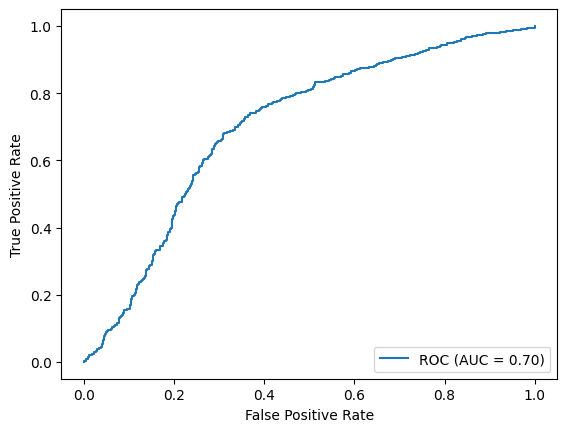

In [293]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(labels), np.array(preds))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC')
display.plot()
plt.show()

In [223]:
np.argmax(np.sqrt(tpr*(1-fpr)))

0

In [186]:
tp=0
tn=0
fp=0
fn=0
with torch.no_grad():
    for sequence, label in tqdm(test_loader):
        sequence = torch.transpose(sequence,0,1)
        sequence = sequence.to(device)
        label = label.to(device)

        output = model.forward(sequence)
        predicted = output.item() > 0.5
        if predicted and label.item():
            tp += 1
        elif predicted:
            fp += 1
        elif label.item():
            fn += 1
        else:
            tn += 1
    acc = 100 * (tp+tn)/(tp+tn+fp+fn)
    trec = 0 if tp==0 else 100*tp/(tp+fn)
    tpre = 0 if tp==0 else 100*tp/(tp+fp)
    frec = 0 if tn==0 else 100*tn/(tn+fp)
    fpre = 0 if tn==0 else 100*tn/(tn+fn)

100%|██████████| 1227/1227 [00:03<00:00, 321.29it/s]


In [187]:
p_pos = 868/1227
p_neg = 359/1227
p_pos_pre = (tp+fp)/1227
p_neg_pre = (tn+fn)/1227
acc = (tp+tn)/1227
p_e = p_pos*p_pos_pre + p_neg*p_neg_pre
print((acc-p_e)/(1-p_e))


0.2803969715325505


In [188]:
print(tp)
print(tn)
print(fp)
print(fn)

421
319
40
447


: 

In [20]:
df = pd.merge(dataDF,userDF[['Parkinsons']], left_on='UserID', right_index=True, how='left')
df['Parkinsons'] = df['Parkinsons'].map({'False':0, 'True':1})
df['Hand'] = df['Hand'].map({'L':1, 'R':2, 'S':0})
df['Direction'] = df['Direction'].map({'LL':0, 'RL':1, 'LR':2, 'RR':3, 'LS':4, 'SL':5, 'RS':6, 'SR':7, 'SS':8})
df['HoldTime'] = df['HoldTime'].astype(float)
df['LatencyTime'] = df['LatencyTime'].astype(float)
df['FlightTime'] = df['FlightTime'].astype(float)
df = df.dropna()

In [21]:
positiveSamples = df[df['Parkinsons']==1]
negativeSamples = df[df['Parkinsons']==0]
positiveGrouped = positiveSamples.groupby('UserID')
negativeGrouped = negativeSamples.groupby('UserID')
positiveUserIDs = np.array(positiveSamples['UserID'].unique())
negativeUserIDs = np.array(negativeSamples['UserID'].unique())
np.random.shuffle(positiveUserIDs)
np.random.shuffle(negativeUserIDs)

train_ratio = 0.7
valid_ratio = 0.2

total_positive_rows = len(positiveSamples)
train_positive_rows = int(total_positive_rows * train_ratio)
valid_positive_rows = int(total_positive_rows * valid_ratio)
total_negative_rows = len(negativeSamples)
train_negative_rows = int(total_negative_rows * train_ratio)
valid_negative_rows = int(total_negative_rows * valid_ratio)

# Initialize empty DataFrames for training, validation, and testing sets
train_df = pd.DataFrame(columns=df.columns)
valid_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

train_positive_count, valid_positive_count = 0, 0
train_negative_count, valid_negative_count = 0, 0
train_data = []
valid_data = []
test_data = []

# Iterate over the shuffled user_ids and assign rows to the corresponding set
for userID in positiveUserIDs:
    user_data = positiveGrouped.get_group(userID)
    user_rows = len(user_data)
    
    if train_positive_count + user_rows <= train_positive_rows:
        train_data.append(user_data)
        train_positive_count += user_rows
    elif valid_positive_count + user_rows <= valid_positive_rows:
        valid_data.append(user_data)
        valid_positive_count += user_rows
    else:
        test_data.append(user_data)

for userID in negativeUserIDs:
    user_data = negativeGrouped.get_group(userID)
    user_rows = len(user_data)
    
    if train_negative_count + user_rows <= train_negative_rows:
        train_data.append(user_data)
        train_negative_count += user_rows
    elif valid_negative_count + user_rows <= valid_negative_rows:
        valid_data.append(user_data)
        valid_negative_count += user_rows
    else:
        test_data.append(user_data)

train_df = pd.concat(train_data)
valid_df = pd.concat(valid_data)
test_df = pd.concat(test_data)
valid_test_df = pd.concat([valid_df, test_df]).reset_index(drop=True)

In [33]:
test_df[test_df['Parkinsons']==1]

,UserID,Date,Timestamp,Hand,HoldTime,Direction,LatencyTime,FlightTime,Parkinsons
1161193,8EY6NZAKCI,160811,19:42:57.969,1,31.3,1,218.8,328.1,1.0
1161194,8EY6NZAKCI,160811,19:42:58.148,2,31.3,2,179.7,148.4,1.0
1161195,8EY6NZAKCI,160811,19:42:58.414,2,31.3,3,265.6,234.4,1.0
1161196,8EY6NZAKCI,160811,19:42:58.656,1,273.4,1,265.6,234.4,1.0
1161197,8EY6NZAKCI,160811,19:43:01.703,1,15.6,0,234.4,375.0,1.0
...,...,...,...,...,...,...,...,...,...
276504,48DZPAJ5NS,160825,13:56:28.559,1,121.1,1,335.9,199.2,1.0
276505,48DZPAJ5NS,160825,13:56:28.758,0,121.1,4,203.1,82.0,1.0
276506,48DZPAJ5NS,160825,13:56:29.930,2,121.1,3,347.7,214.8,1.0
276507,48DZPAJ5NS,160825,13:56:31.094,1,164.1,0,437.5,324.2,1.0


In [13]:
from torch import nn
import torch
device = "cuda"

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [14]:
feature_columns = ['Hand','HoldTime','Direction','LatencyTime']
label_column = 'Parkinsons'

X_train = torch.tensor(train_df[feature_columns].values, dtype=torch.float32).to(device)
y_train = torch.tensor(train_df[label_column].values, dtype=torch.float32).unsqueeze(1).to(device)

X_valid = torch.tensor(valid_df[feature_columns].values, dtype=torch.float32).to(device)
y_valid = torch.tensor(valid_df[label_column].values, dtype=torch.float32).unsqueeze(1).to(device)

X_test = torch.tensor(test_df[feature_columns].values, dtype=torch.float32).to(device)
y_test = torch.tensor(test_df[label_column].values, dtype=torch.float32).unsqueeze(1).to(device)

In [15]:
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)

model = MLP().to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the MLP model on the training set and evaluate on the validation set
best_loss = float('inf')
for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Evaluate the model on the validation set
    with torch.no_grad():
        total_val_loss = 0
        for inputs, labels in tqdm(val_dataloader):
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss = total_val_loss + val_loss
        if total_val_loss < best_loss:
            best_loss = total_val_loss
            best_model = model.state_dict()
    print('Epoch %d train loss: %.3f val loss: %.3f' % (epoch + 1, running_loss / len(X_train), total_val_loss))

# Load the best model and evaluate it on the testing set
model.load_state_dict(best_model)
with torch.no_grad():
    test_tp = test_tn = test_fp = test_fn = 0
    for inputs, labels in tqdm(test_dataloader):
        test_outputs = model(inputs)
        test_predictions = (test_outputs > 0.5).float()
        test_tp = test_tp + ((test_predictions == 1) & (labels == 1)).sum().item()
        test_tn = test_tn + ((test_predictions == 0) & (labels == 0)).sum().item()
        test_fp = test_fp + ((test_predictions == 1) & (labels == 0)).sum().item()
        test_fn = test_fn + ((test_predictions == 0) & (labels == 1)).sum().item()
    
print('True positives:', test_tp)
print('True negatives:', test_tn)
print('False positives:', test_fp)
print('False negatives:', test_fn)

100%|██████████| 44254/44254 [00:29<00:00, 1492.24it/s]


Epoch 1 train loss: 0.018 val loss: 1.401


100%|██████████| 44254/44254 [00:29<00:00, 1486.38it/s]


Epoch 2 train loss: 0.018 val loss: 1.671


100%|██████████| 44254/44254 [00:29<00:00, 1487.28it/s]


Epoch 3 train loss: 0.018 val loss: 1.397


100%|██████████| 44254/44254 [00:31<00:00, 1417.44it/s]


Epoch 4 train loss: 0.018 val loss: 1.576


100%|██████████| 44254/44254 [00:31<00:00, 1427.04it/s]


Epoch 5 train loss: 0.018 val loss: 1.501


100%|██████████| 44254/44254 [00:31<00:00, 1424.88it/s]


Epoch 6 train loss: 0.018 val loss: 1.543


100%|██████████| 44254/44254 [00:30<00:00, 1431.19it/s]


Epoch 7 train loss: 0.018 val loss: 1.554


100%|██████████| 44254/44254 [00:31<00:00, 1383.20it/s]


Epoch 8 train loss: 0.018 val loss: 1.627


100%|██████████| 44254/44254 [00:30<00:00, 1449.53it/s]


Epoch 9 train loss: 0.018 val loss: 1.575


100%|██████████| 44254/44254 [00:30<00:00, 1449.67it/s]


Epoch 10 train loss: 0.018 val loss: 1.451


100%|██████████| 40812/40812 [00:47<00:00, 864.75it/s]

True positives: 633086
True negatives: 22503
False positives: 636308
False negatives: 14077


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/model.pth')


In [27]:
633086 / (118972 + 135540)

0.4674514364745081

In [8]:
118972 TP
211097 TN
46010 FP
135540 FN

118972

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

feature_columns = ['HoldTime'] # ['Hand','HoldTime','Direction','LatencyTime']
label_column = 'Parkinsons'
X_train = train_df[feature_columns]
y_train = train_df[label_column]

X_test = valid_test_df[feature_columns]
y_test = valid_test_df[label_column]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = LinearSVC(verbose=2,max_iter=1000,C=0.01)
svm.fit(X_train_scaled, y_train)

y_test_pred = svm.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.4f}')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()